In [2]:
import pandas as pd
import random
import numpy as np
import copy
import matplotlib.pyplot as plt
import collections
from collections import deque  # Add this import

!which python

/Users/berat/Desktop/quantum_entanglement/.venv/bin/python


In [22]:
class QuantumInternet():
    def __init__(self, initialEdges, pGen, cutOffAge, goalStates, goalWeights):
        self.initialEdges = initialEdges  
        self.currentEdges = {} 
        self.pGen = pGen
        self.cutOffAge = cutOffAge
        self.goalStates = goalStates
        self.goalWeights = goalWeights
        self.maxLinks = 1
        # Add counters for EDR calculation
        self.total_timesteps = 0
        self.successful_links = 0
        ######
    
    def reset(self) -> None:
        self.currentEdges = {} 
        # Generate initial entanglements
        self.globallyGenerateEntanglements()
        return self.currentEdges  # Return the initial state (better for existing implementation)
    
    def getState(self) -> dict:
        return self.currentEdges
    
    def isTerminal(self) -> tuple[bool, list]:
        graph = collections.defaultdict(set)
        for (a, b) in self.currentEdges:
            graph[a].add(b)
            graph[b].add(a)
        
        def has_path(start, end):
            if start == end:
                return True
            
            visited = set()
            stack = [start]
            
            while stack:
                current = stack.pop()
                if current not in visited:
                    visited.add(current)
                    
                    if current == end:
                        return True
                    
                    # Add unvisited neighbors to stack
                    stack.extend(
                        next_node for next_node in graph[current] 
                        if next_node not in visited
                    )
            
            return False
        
        matching = [goal for goal in self.goalStates if has_path(goal[0], goal[-1])]
        return bool(matching), matching
                
        
    def generateEntanglement(self, node1, node2):
        edge = tuple(sorted([node1, node2]))
        if edge not in self.currentEdges:
            self.currentEdges[edge] = deque([0])
        else:
            if len(self.currentEdges[edge]) < self.maxLinks:
                self.currentEdges[edge].appendleft(0)

    def globallyGenerateEntanglements(self):
        for edge in self.initialEdges:
            if random.random() < self.pGen:
                self.generateEntanglement(*edge)
    
    def discardEntanglement(self, edge: tuple):
        if edge in self.currentEdges and len(self.currentEdges[edge]) > 0:
            self.currentEdges[edge].pop()
            if len(self.currentEdges[edge]) == 0:
                del self.currentEdges[edge]
    
    def ageEntanglements(self):
        edges_to_check = list(self.currentEdges.keys())
        for edge in edges_to_check:
            newAges = [age + 1 for age in self.currentEdges[edge] if age + 1 <= self.cutOffAge]
            self.currentEdges[edge] = deque(newAges)
            
            if len(self.currentEdges[edge]) == 0:
                self.discardEntanglement(edge)
                
    def rewardForAction(self, action):
        self.total_timesteps += 1
        
        if not action:  # If waiting
            return 0
            
        # Check if we have a successful path
        is_terminal, matching = self.isTerminal()
        
        if not is_terminal:
            return 0
        
        # Update successful links counter
        self.successful_links += 1
        
        # Calculate EDR (avoid division by zero)
        edr = self.successful_links / max(1, self.total_timesteps)
        
        # Calculate path length for matched goals
        total_reward = 0
        for i, path in enumerate(matching):
            # Calculate number of edges in path
            path_length = len(path) - 1
            # Calculate reward using formula: goalWeight * p^path_length / edr
            reward = (self.goalWeights[i] * (self.pGen ** (2 * path_length))) / edr
            total_reward += reward
            
        return total_reward
            
        

In [23]:
random.seed(27)
initialEdges = [(1,3), (2,3), (3,4), (4,5), (6,7), (6,8)]
goalStates = [(1, 3), (1,8)]
goalWeights = [0.5, 0.5]
pGen = 0.75
cutOffAge = 1

myNetwork = QuantumInternet(initialEdges, pGen, cutOffAge, goalStates, goalWeights)
myNetwork.getState()
myNetwork.globallyGenerateEntanglements()
myNetwork.ageEntanglements()
print(myNetwork.getState())
myNetwork.isTerminal()    

{(1, 3): deque([1]), (2, 3): deque([1]), (4, 5): deque([1]), (4, 6): deque([1])}


(True, [(1, 3)])

In [24]:
def epsilon_greedy_policy(Q, state_key, epsilon):
    # state_key is already a tuple, no need to convert again
    if np.random.rand() < epsilon:
        # Exploration: randomly choose between attempting path or waiting
        return random.choice([True, False])
    else:
        # Exploitation: choose action with highest Q-value
        if state_key not in Q:
            Q[state_key] = {True: 0, False: 0}  # Initialize both actions
        
        return max(Q[state_key].items(), key=lambda x: x[1])[0]

In [29]:
n = 5  # number of steps
alpha = 0.1  # learning rate
gamma = 0.99  # discount factor
epsilon = 0.1  # exploration rate
num_episodes = 10000


In [30]:
Q = {}  # State-action value function

def n_step_sarsa(env, n, alpha, gamma, epsilon, num_episodes):
    global Q
    episode_rewards = np.zeros(num_episodes)
    max_steps_per_episode = 1000  # Add a maximum step limit
    
    for episode in range(num_episodes):
        print(f"Episode {episode}")
        state = env.reset()
        # Convert state to hashable format for Q-table
        state_key = tuple(
            (edge, tuple(ages))
            for edge, ages in sorted(state.items())
        )
        
        action = epsilon_greedy_policy(Q, state_key, epsilon)
        
        T = float('inf')
        t = 0
        tau = 0
        
        # Store states, actions, rewards
        states = [state_key]
        actions = [action]
        rewards = []
        
        while tau < (T - 1) and t < max_steps_per_episode:  # Add step limit check
            if t < T:
                # Take action and get reward
                reward = env.rewardForAction(action)
                rewards.append(reward)
                
                # Age entanglements and generate new ones
                env.ageEntanglements()
                env.globallyGenerateEntanglements()
                
                # Get next state
                next_state = env.getState()
                is_terminal, _ = env.isTerminal()
                
                # Convert next_state to hashable format
                next_state_key = tuple(
                    (edge, tuple(ages))
                    for edge, ages in sorted(next_state.items())
                )
                states.append(next_state_key)
                
                if is_terminal:
                    T = t + 1
                else:
                    next_action = epsilon_greedy_policy(Q, next_state_key, epsilon)
                    actions.append(next_action)
            
            tau = t - n + 1
            
            if tau >= 0:
                # Calculate n-step return
                G = sum([gamma**(i - tau - 1) * rewards[i] 
                        for i in range(tau + 1, min(tau + n, T))])
                
                if tau + n < T:
                    if states[tau + n] not in Q:
                        Q[states[tau + n]] = {True: 0, False: 0}
                    G += gamma**n * Q[states[tau + n]][actions[tau + n]]
                
                # Update Q-value
                if states[tau] not in Q:
                    Q[states[tau]] = {True: 0, False: 0}
                Q[states[tau]][actions[tau]] += alpha * (G - Q[states[tau]][actions[tau]])
            
            t += 1
            state = next_state
            action = next_action if t < T else None
        
        episode_rewards[episode] = sum(rewards)
        print(f"Episode {episode} completed in {t} steps with total reward {episode_rewards[episode]}")
    
    return Q, episode_rewards

n_step_sarsa(myNetwork, n, alpha, gamma, epsilon, num_episodes)

Episode 0
Episode 0 completed in 5 steps with total reward 0.8488154613466333
Episode 1
Episode 1 completed in 5 steps with total reward 0.0
Episode 2
Episode 2 completed in 5 steps with total reward 0.42442685967585536
Episode 3
Episode 3 completed in 6 steps with total reward 0.0
Episode 4
Episode 4 completed in 5 steps with total reward 0.8489698753462603
Episode 5
Episode 5 completed in 6 steps with total reward 0.0
Episode 6
Episode 6 completed in 5 steps with total reward 0.8490859991690901
Episode 7
Episode 7 completed in 5 steps with total reward 0.42452315840487403
Episode 8
Episode 8 completed in 5 steps with total reward 0.4245033227190918
Episode 9
Episode 9 completed in 5 steps with total reward 0.8489669850498339
Episode 10
Episode 10 completed in 5 steps with total reward 0.0
Episode 11
Episode 11 completed in 5 steps with total reward 0.0
Episode 12
Episode 12 completed in 5 steps with total reward 0.0
Episode 13
Episode 13 completed in 5 steps with total reward 0.42458

({(((1, 3), (0,)), ((3, 4), (0,)), ((4, 5), (0,)), ((4, 6), (0,))): {True: 0.0,
   False: 0.0},
  (((2, 3), (0,)), ((4, 5), (0,))): {True: 0.0, False: 0.0},
  (((1, 3), (0,)), ((4, 5), (0,)), ((4, 6), (0,))): {True: 0.0, False: 0.0},
  (((2, 3), (1,)), ((3, 4), (1,)), ((4, 5), (1,)), ((4, 6), (1,))): {True: 0.0,
   False: 0.0},
  (((2, 3), (0,)), ((3, 4), (0,)), ((4, 5), (0,)), ((4, 6), (0,))): {True: 0.0,
   False: 0.0},
  (((1, 3), (0,)),
   ((2, 3), (0,)),
   ((3, 4), (0,)),
   ((4, 5), (0,)),
   ((4, 6), (0,))): {True: 0.0, False: 0.0},
  (((3, 4), (0,)), ((4, 5), (0,)), ((4, 6), (0,))): {True: 0.0, False: 0.0},
  (((2, 3), (0,)), ((3, 4), (1,)), ((4, 5), (1,)), ((4, 6), (1,))): {True: 0.0,
   False: 0.0},
  (((1, 3), (0,)), ((2, 3), (0,)), ((4, 5), (0,)), ((4, 6), (0,))): {True: 0.0,
   False: 0.0},
  (((1, 3), (0,)), ((3, 4), (0,)), ((4, 5), (0,))): {True: 0.0, False: 0.0},
  (((1, 3), (0,)), ((3, 4), (0,)), ((4, 6), (0,))): {True: 0.0, False: 0.0},
  (((1, 3), (0,)), ((3, 4), (0

Eval Episode 0: Steps=1, Reward=0.8531315422191208
Eval Episode 1: Steps=1, Reward=0.8531112622985138
Eval Episode 2: Steps=1, Reward=0.42654549260396313
Eval Episode 3: Steps=1, Reward=0.8530707109467661
Eval Episode 4: Steps=1, Reward=0.8530504395144412
Eval Episode 5: Steps=1, Reward=0.8530301709103593
Eval Episode 6: Steps=1, Reward=0.42650495256696425
Eval Episode 7: Steps=1, Reward=0.8529896421845574
Eval Episode 8: Steps=1, Reward=0
Eval Episode 9: Steps=1, Reward=0.42650430673734135
Eval Episode 10: Steps=1, Reward=0.42649417672083134
Eval Episode 11: Steps=1, Reward=0.8529680962343096
Eval Episode 12: Steps=1, Reward=0.8529478418520327
Eval Episode 13: Steps=1, Reward=0.8529275902942407
Eval Episode 14: Steps=1, Reward=0.4264536707801715
Eval Episode 15: Steps=1, Reward=0.852887095649749
Eval Episode 16: Steps=1, Reward=0.4264334262809341
Eval Episode 17: Steps=1, Reward=0.8528466122961105
Eval Episode 18: Steps=1, Reward=0.8528263748518854
Eval Episode 19: Steps=1, Reward=0.8

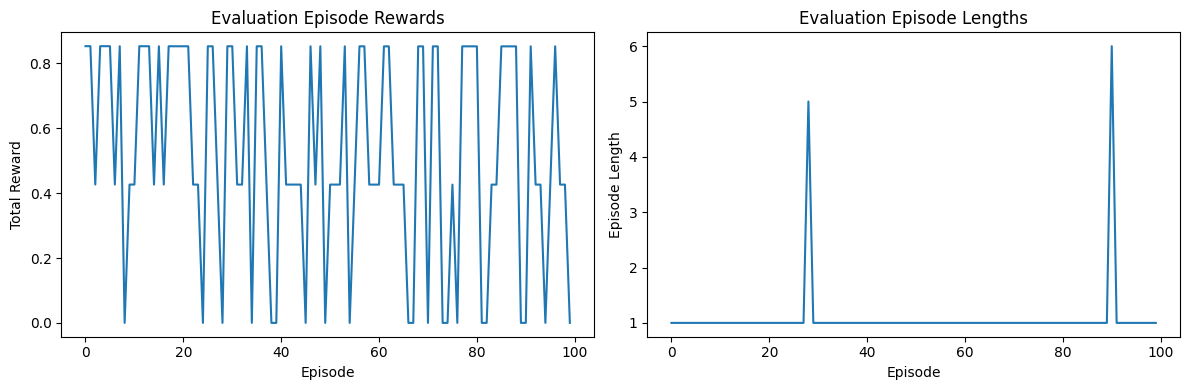

In [31]:
def evaluate_policy(env, Q, num_eval_episodes=100, max_steps=1000):
    """
    Evaluate the learned policy without exploration
    """
    eval_rewards = []
    eval_lengths = []
    success_rate = 0
    
    for episode in range(num_eval_episodes):
        state = env.reset()
        episode_reward = 0
        steps = 0
        done = False
        
        while not done and steps < max_steps:
            # Convert state to hashable format
            state_key = tuple(
                (edge, tuple(ages))
                for edge, ages in sorted(state.items())
            )
            
            # Get action from Q-table (no exploration)
            if state_key not in Q:
                action = False  # Default to waiting if state not seen
            else:
                action = max(Q[state_key].items(), key=lambda x: x[1])[0]
            
            # Take action
            reward = env.rewardForAction(action)
            episode_reward += reward
            
            # Update state
            env.ageEntanglements()
            env.globallyGenerateEntanglements()
            state = env.getState()
            
            # Check if terminal
            done, matching = env.isTerminal()
            if done and action:  # Successful link
                success_rate += 1
            
            steps += 1
        
        eval_rewards.append(episode_reward)
        eval_lengths.append(steps)
        
        print(f"Eval Episode {episode}: Steps={steps}, Reward={episode_reward}")
    
    # Calculate statistics
    avg_reward = np.mean(eval_rewards)
    avg_length = np.mean(eval_lengths)
    success_rate = success_rate / num_eval_episodes
    
    print("\nEvaluation Results:")
    print(f"Average Reward: {avg_reward:.2f}")
    print(f"Average Episode Length: {avg_length:.2f}")
    print(f"Success Rate: {success_rate:.2%}")
    
    # Plot results
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(eval_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Evaluation Episode Rewards')
    
    plt.subplot(1, 2, 2)
    plt.plot(eval_lengths)
    plt.xlabel('Episode')
    plt.ylabel('Episode Length')
    plt.title('Evaluation Episode Lengths')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'avg_reward': avg_reward,
        'avg_length': avg_length,
        'success_rate': success_rate,
        'rewards': eval_rewards,
        'lengths': eval_lengths
    }

# After training, evaluate the policy
eval_results = evaluate_policy(myNetwork, Q)